In [14]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 10 10:59:39 2019

@author: Katherine, Ki Wan
"""

import csv
import os
from functools import partial
import json
import numpy as np
import geopandas as gpd
import matplotlib

import matplotlib.pyplot as plt
#import seaborn as sns
import networkx as nx
import random


from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept



In [15]:
num_districts = 13
output_dirname = "Run_1"

newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")
    
graph = Graph.from_json("./data/ga_tract.json")
df = gpd.read_file("./data/ga_2012_tract.shp")


In [16]:
# SUMMING DATA WE WANT IN THE DATAFRAME
import pandas as pd 

new_cols = ['CPOP', 'VAP', 'BVAP', 'nBVAP', 'BHVAP', 'nBHVAP', 'CVAP', 'BCVAP', 'nBCVAP', 'BHCVAP', 'nBHCVAP']

VAP_cols = ['MVAPTOT', 'FVAPTOT']
BVAP_cols = ['MVAPBLK', 'FVAPBLK']
HVAP_cols = ['MVAPHISP', 'FVAPHISP']
CVAP_cols = ['MNVVAPTOT', 'MNLVAPTOT', 'FNVVAPTOT', 'FNLVAPTOT']
BCVAP_cols = ['MNVVAPBLK', 'MNLVAPBLK', 'FNVVAPBLK', 'FNLVAPBLK']
HCVAP_cols = ['MNVVAPHISP', 'MNLVAPHISP', 'FNVVAPHISP', 'FNLVAPHISP']


df['CPOP'] = pd.to_numeric(df['TOTPOP']-df['NCPOP'])
df['VAP'] = pd.to_numeric(df[VAP_cols].sum(axis=1))
df['BVAP'] = pd.to_numeric(df[BVAP_cols].sum(axis=1))
df['nBVAP'] = df['VAP'] - df['BVAP']
df['CVAP'] = pd.to_numeric(df[CVAP_cols].sum(axis=1))
df['BCVAP'] = pd.to_numeric(df[BCVAP_cols].sum(axis=1))
df['nBCVAP'] = df['CVAP'] - df['BCVAP']

df['BHVAP'] = pd.to_numeric(df['BVAP'] + df[HVAP_cols].sum(axis=1))
df['nBHVAP'] = df['VAP'] - df['BHVAP']
df['BHCVAP'] = pd.to_numeric(df['BCVAP'] + df[HCVAP_cols].sum(axis=1))
df['nBHCVAP'] = df['CVAP'] - df['BHCVAP']




In [17]:
# ADD NEW DATA TO GRAPH 

graph.add_data(df, columns=new_cols)

In [32]:
# INITIAL PARTITION ASSIGNMENT USING RECURSIVE TREE PARTITION

starts = []

for i in range(1):
    starts.append(recursive_tree_part(graph,range(num_districts),df['TOTPOP'].sum()/num_districts, "TOTPOP", .001, 1))


In [35]:
updater = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "CVAP" : updaters.Tally("CVAP", alias="CVAP"),
    "cut_edges": cut_edges,
    "BVAP":Election("BVAP",{"BVAP":"BVAP","nBVAP":"nBVAP"}),
    "BCVAP":Election("BCVAP",{"BCVAP":"BCVAP","nBCVAP":"nBCVAP"})
}

initial_partitions = []
proposals = []
compactness_bounds = []
chains=[]

for i in range(1):
    initial_partitions.append(Partition(graph,starts[i], updater))
    print("initial partition is made")

    proposals.append(partial(
        recom, pop_col="TOTPOP", pop_target=df['TOTPOP'].sum()/num_districts, epsilon=0.01, node_repeats=1 # e = .02
    ))

    compactness_bounds.append(constraints.UpperBound(
        lambda p: len(p["cut_edges"]), 2 * len(initial_partitions[i]["cut_edges"])
    ))

    chains.append(MarkovChain(
        proposal=proposals[i],
        constraints=[
            constraints.within_percent_of_ideal_population(initial_partitions[i], .01), compactness_bounds[i] # e = .05
          #constraints.single_flip_contiguous#no_more_discontiguous 
        #constraints.within_percent_of_ideal_population(initial_partitions[i], .3)
        ],
        accept=always_accept,
        initial_state=initial_partitions[i],
        total_steps=10000
    ))


initial partition is made


chain 0 step 100
chain 0 step 200
chain 0 step 300
chain 0 step 400
chain 0 step 500
chain 0 step 600
chain 0 step 700
chain 0 step 800
chain 0 step 900
chain 0 step 1000
chain 0 step 1100
chain 0 step 1200
chain 0 step 1300
chain 0 step 1400
chain 0 step 1500
chain 0 step 1600
chain 0 step 1700
chain 0 step 1800
chain 0 step 1900
chain 0 step 2000
chain 0 step 2100
chain 0 step 2200
chain 0 step 2300
chain 0 step 2400
chain 0 step 2500
chain 0 step 2600
chain 0 step 2700
chain 0 step 2800
chain 0 step 2900
chain 0 step 3000
chain 0 step 3100
chain 0 step 3200
chain 0 step 3300
chain 0 step 3400
chain 0 step 3500
chain 0 step 3600
chain 0 step 3700
chain 0 step 3800
chain 0 step 3900
chain 0 step 4000
chain 0 step 4100
chain 0 step 4200
chain 0 step 4300
chain 0 step 4400
chain 0 step 4500
chain 0 step 4600
chain 0 step 4700
chain 0 step 4800
chain 0 step 4900
chain 0 step 5000
chain 0 step 5100
chain 0 step 5200
chain 0 step 5300
chain 0 step 5400
chain 0 step 5500
chain 0 step 5600
c

AttributeError: 'Line2D' object has no property 'column'

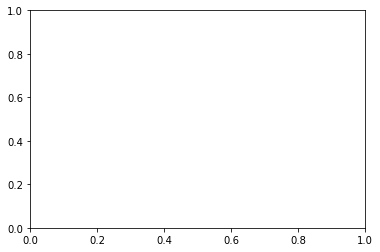

In [75]:
cuts=[[],[],[],[]]
BVAPS=[[],[],[],[]]
BCVAPS=[[],[],[],[]]
TOTPOP=[]
CVAP=[]

#37 to 55 is opportunity district BVAP range in VA

subdir = "./Outputs/Tract_13Districts_VAP_CVAP/"
os.makedirs(os.path.dirname(subdir + "init.txt"), exist_ok=True)
with open(subdir + "init.txt", "w") as f:
    f.write("Created Folder")

for i in range(1):
    t = 0
    for part in chains[i]:
        cuts[i].append(len(part["cut_edges"]))
        BVAPS[i].append(sorted(part["BVAP"].percents("BVAP")))
        BCVAPS[i].append(sorted(part["BCVAP"].percents("BCVAP")))
        TOTPOP.append(sorted(list(part["population"].values())))
        CVAP.append(sorted(list(part["CVAP"].values())))
        
        t+=1
    
        if t%100 ==0:
            print("chain",i,"step",t)
            
        
    print(f"finished chain {i}")

df["final"]=df.index.map(dict(part.assignment))

df.plot(column="final",cmap="jet")
plt.savefig(subdir+"final.png")
plt.close()


In [38]:
# Note:
#
# The "enacted plan" is taken from the 2012 congressional district data for 13 districts
# because GA gained a seat iin 2012 to have 14 seats in 2013. 
# 

cd_df = gpd.read_file("./data/ga_2012_CD.shp")

In [39]:
new_cols = ['CPOP', 'VAP', 'BVAP', 'nBVAP', 'CVAP', 'BCVAP', 'nBCVAP']

VAP_cols = ['MVAPTOT', 'FVAPTOT']
BVAP_cols = ['MVAPBLK', 'FVAPBLK']
CVAP_cols = ['MNVVAPTOT', 'MNLVAPTOT', 'FNVVAPTOT', 'FNLVAPTOT']
BCVAP_cols = ['MNVVAPBLK', 'MNLVAPBLK', 'FNVVAPBLK', 'FNLVAPBLK']

cd_df['CPOP'] = pd.to_numeric(cd_df['TOTPOP']-cd_df['NCPOP'])
cd_df['VAP'] = pd.to_numeric(cd_df[VAP_cols].sum(axis=1))
cd_df['BVAP'] = pd.to_numeric(cd_df[BVAP_cols].sum(axis=1))
cd_df['nBVAP'] = cd_df['VAP'] - cd_df['BVAP']
cd_df['CVAP'] = pd.to_numeric(cd_df[CVAP_cols].sum(axis=1))
cd_df['BCVAP'] = pd.to_numeric(cd_df[BCVAP_cols].sum(axis=1))
cd_df['nBCVAP'] = cd_df['CVAP'] - cd_df['BCVAP']


In [40]:
enacted_CD112_BCVAP = sorted(cd_df['BCVAP']/cd_df['CVAP'])

In [41]:
enacted_CD112_BVAP = sorted(cd_df['BVAP']/cd_df['VAP'])

In [103]:
enacted_CD112_CVAP = sorted(cd_df['CVAP'])
enacted_CD112_TOTPOP = sorted(cd_df['TOTPOP'])

In [85]:
import json
from pprint import pprint

CVAP_based_BCVAP_json = './data/results_json/CD13_CVAP_based_BCVAP.json'
CVAP_based_BVAP_json = './data/results_json/CD13_CVAP_based_BVAP.json'
CVAP_json = './data/results_json/CD13_CVAP_based_CVAP_population.json'
TOTPOP_json = './data/results_json/CD13_CVAP_based_TOTPOP_population.json'

with open(CVAP_based_BCVAP_json) as f:
    data = json.load(f)
    BCVAP_percents = data['CVAP_based_BCVAP']

with open(CVAP_based_BVAP_json) as f:
    data = json.load(f)
    BVAP_percents = data['CVAP_based_BVAP']
    
with open(CVAP_json) as f:
    data = json.load(f)
    CVAP_pops = data['CVAP_based_CVAP']

with open(TOTPOP_json) as f:
    data = json.load(f)
    TOTPOP_pops = data['CVAP_based_TOTPOP']


<Figure size 432x288 with 0 Axes>

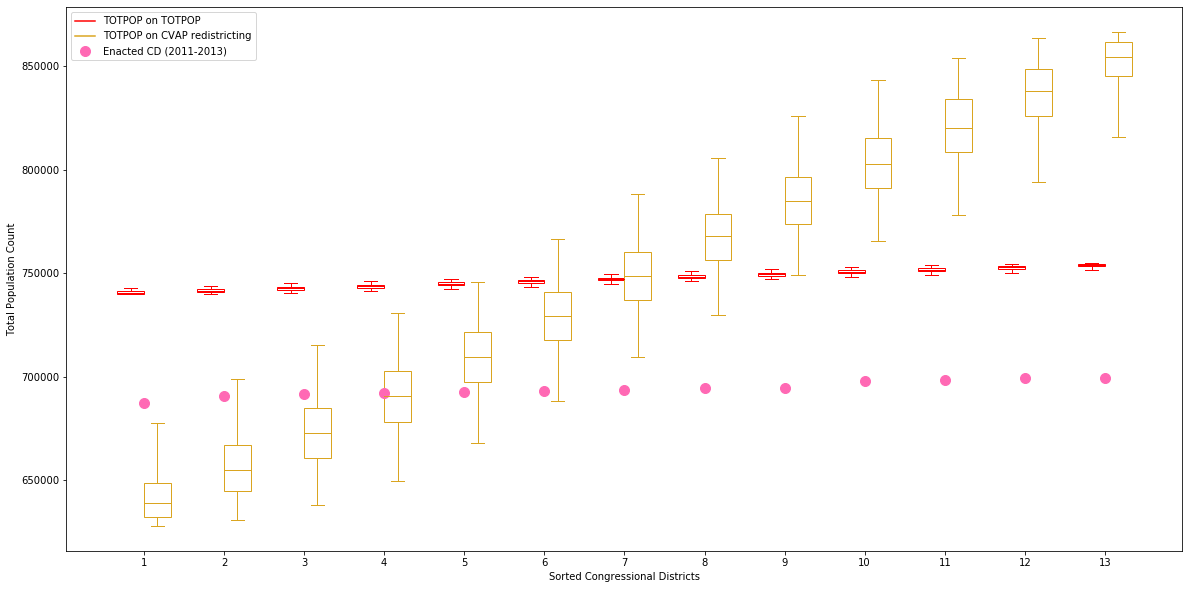

In [137]:
colors = ['red','goldenrod']
labels= ['TOTPOP on TOTPOP','TOTPOP on CVAP redistricting']

plt.figure()

fig, ax = plt.subplots(figsize=(20,10))
draw_plot(np.array(TOTPOP),-1.5,colors[0],'w')
draw_plot(np.array(TOTPOP_pops),-.5,colors[1],'w')
#draw_plot(np.array(BHVAPS[0]),.5,colors[2],'w')
#draw_plot(np.array(BHCVAPS[0]),1.5,colors[3],'w')
sorted_d_nums = [0, 1,2,3,4,5,6,7, 8, 9, 10, 11, 12]
x_labels = [1,2,3,4,5,6,7, 8, 9, 10, 11, 12, 13]
offset_xaxis = [x * 3 for x in sorted_d_nums]
#ax.set_xticklabels(sorted_d_nums)
plt.xticks(offset_xaxis, x_labels)

plt.ylabel("Total Population Count")
plt.xlabel("Sorted Congressional Districts")

for i in range(2):
    plt.plot([],[],color=colors[i],label=labels[i])

plt.plot(offset_xaxis, enacted_CD112_TOTPOP, 'o', color="hotpink", label="Enacted CD (2011-2013)",markersize=10)

plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

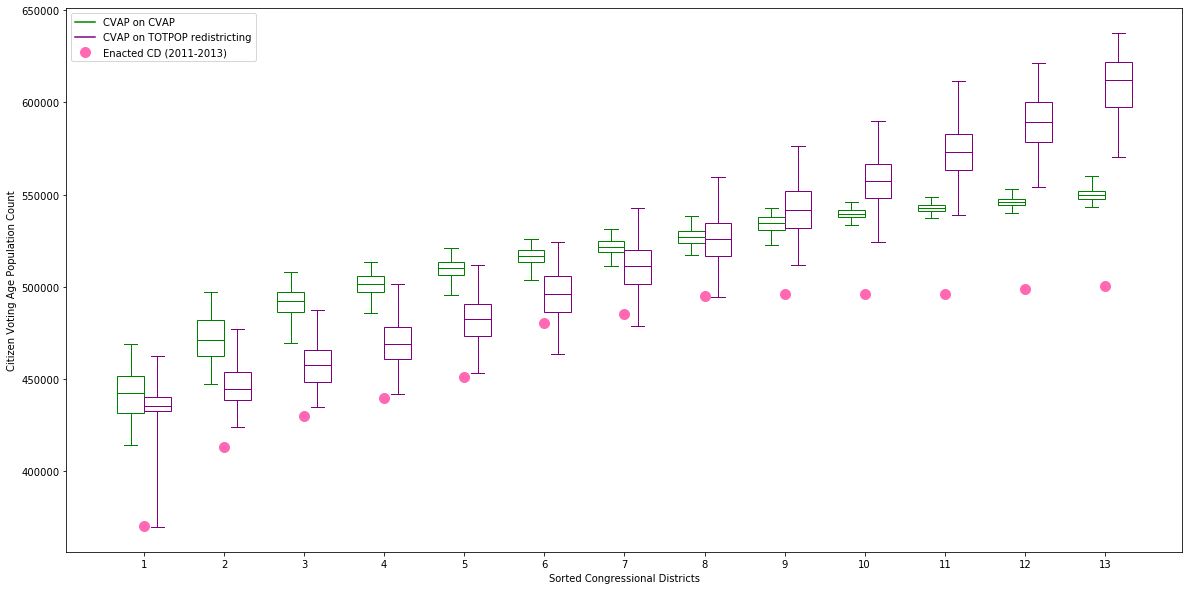

In [135]:
colors = ['green','purple']
labels= ['CVAP on CVAP','CVAP on TOTPOP redistricting']

plt.figure()

fig, ax = plt.subplots(figsize=(20,10))
draw_plot(np.array(CVAP),-1.5,colors[0],'w')
draw_plot(np.array(CVAP_pops),-.5,colors[1],'w')
#draw_plot(np.array(BHVAPS[0]),.5,colors[2],'w')
#draw_plot(np.array(BHCVAPS[0]),1.5,colors[3],'w')
sorted_d_nums = [0,1,2,3,4,5,6,7, 8, 9, 10, 11, 12]
offset_xaxis = [x * 3 for x in sorted_d_nums]

plt.xticks(offset_xaxis, x_labels)

plt.ylabel("Citizen Voting Age Population Count")
plt.xlabel("Sorted Congressional Districts")

for i in range(2):
    plt.plot([],[],color=colors[i],label=labels[i])

plt.plot(offset_xaxis, enacted_CD112_CVAP, 'o', color="hotpink", label="Enacted CD (2011-2013)",markersize=10)
plt.legend()
plt.show()

In [147]:
def draw_plot(data, offset, edge_color, fill_color):
    pos = 3* np.arange(data.shape[1])+1+offset
    #bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_ticks=False)
    bp = ax.boxplot(data, positions= pos,widths=.5, whis=[1,99],showfliers=False, patch_artist=True, manage_ticks=False,zorder=4)
    for element in ['boxes', 'whiskers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color,zorder=4)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,zorder=0)



<Figure size 432x288 with 0 Axes>

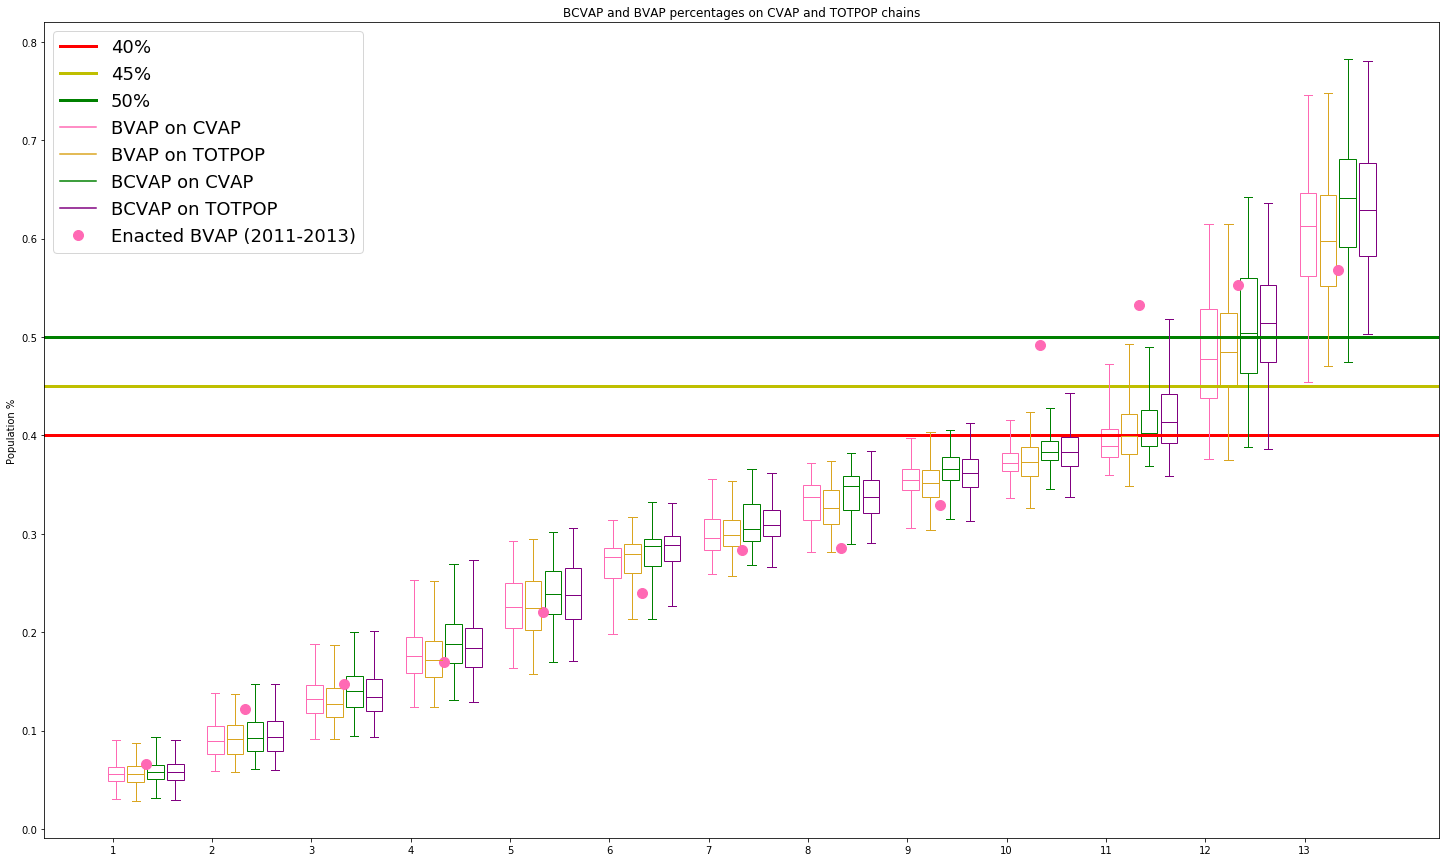

In [162]:
colors = ['hotpink','goldenrod','green','purple']
labels= ['BVAP on CVAP','BVAP on TOTPOP', 'BCVAP on CVAP', 'BCVAP on TOTPOP']

plt.figure()

fig, ax = plt.subplots(figsize=(25,15))
draw_plot(np.array(BVAPS[0]),-.9,colors[0],'w')
draw_plot(np.array(BVAP_percents),-.3,colors[1],'w')
draw_plot(np.array(BCVAPS[0]),.3,colors[2],'w')
draw_plot(np.array(BCVAP_percents),.9,colors[3],'w')

sorted_d_nums = [0,1,2,3,4,5,6,7, 8, 9, 10, 11, 12]
offset_xaxis = [x * 3 for x in sorted_d_nums]
plt.xticks(offset_xaxis, x_labels)

plt.axhline(y=.4,color='r',label="40%",linewidth=3)

plt.axhline(y=.45,color='y',label="45%",linewidth=3)

plt.axhline(y=.5,color='g',label="50%",linewidth=3)
plt.ylabel("Population %")

for i in range(4):
    plt.plot([],[],color=colors[i],label=labels[i])

    
enacted_xaxis = [(x * 3)+1 for x in sorted_d_nums]
plt.plot(enacted_xaxis, enacted_CD112_BVAP, 'o', color="hotpink", label="Enacted BVAP (2011-2013)",markersize=10)
plt.title("BCVAP and BVAP percentages on CVAP and TOTPOP chains")
plt.legend(prop={'size':18})
plt.show()

#set figure size 

IndexError: tuple index out of range

<Figure size 432x288 with 0 Axes>

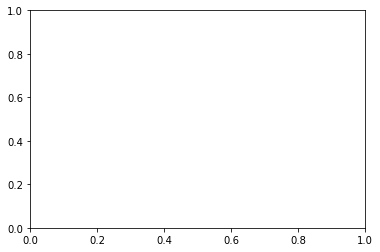

In [73]:
colors = ['hotpink','goldenrod','green','purple']
labels= ['BVAP on CVAP','BVAP on TOTPOP']

plt.figure()

fig, ax = plt.subplots()
draw_plot(np.array(CVAP),-1.5,colors[0],'w')
draw_plot(np.array(CVAP_pop),-.5,colors[1],'w')
#draw_plot(np.array(BHVAPS[0]),.5,colors[2],'w')
#draw_plot(np.array(BHCVAPS[0]),1.5,colors[3],'w')
sorted_d_nums = [1,2,3,4,5,6,7, 8, 9, 10, 11, 12, 13]

#ax.set_xticklabels(sorted_d_nums)
plt.axhline(y=.4,color='r',label="40%",linewidth=1)

plt.axhline(y=.45,color='y',label="45%",linewidth=1)

plt.axhline(y=.5,color='g',label="50%",linewidth=1)
plt.ylabel("Population %")

for i in range(2):
    plt.plot([],[],color=colors[i],label=labels[i])

#plt.plot(sorted_d_nums, enacted_CD112_BVAP, 'o', color="hotpink", label="Enacted (2013)",markersize=10)

plt.legend()
plt.show()

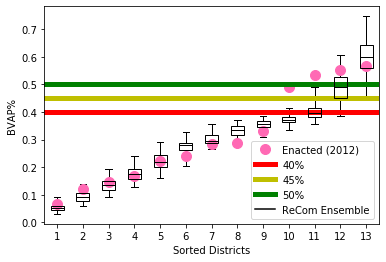

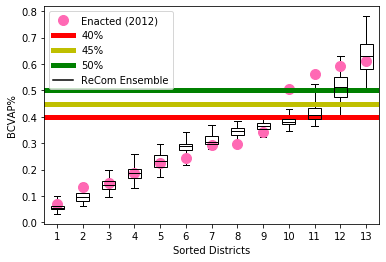

In [52]:
# PLOT SORTED DISTRICTS OVER BVAP %

c='k'

#37 to 55 is opportunity district BVAP range in VA

plt.figure()
plt.boxplot(
            np.array(BVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13], enacted_CD112_BVAP, 'o', color="hotpink", label="Enacted (2012)",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("BVAP%")

plt.legend()

plt.show()


# PLOT SORTED DISTRICTS OVER CBVAP %

plt.figure()
plt.boxplot(
            np.array(BCVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13], enacted_CD112_BCVAP, 'o', color="hotpink", label="Enacted (2012)",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("BCVAP%")

plt.legend()

plt.show()

In [102]:
#  things to change:
#  obj = {"[replace]_based_[replace]" : list(np.array(REPLACE).flatten())}

outputdir = './data/results_json/'
obj = {"array" : list(CVAP)}

with open(outputdir+"CD13_TOTPOPchain_CVAPvalues.json", 'w') as jf1:
    json.dump(dict(obj), jf1)